<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using arterial blood pressure waveform

In this sample code, we will try to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the arterial blood pressure waveform (ART) in the VitalDB dataset.

## Required libraries

In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

!pip install vitaldb
import vitaldb

## Case Selection

In [20]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[df_cases['weight'] >= 30]['caseid']) & 
    set(df_cases[df_cases['weight'] < 140]['caseid']) & 
    set(df_cases[df_cases['height'] >= 135]['caseid']) & 
    set(df_cases[df_cases['height'] < 200]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("heart")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("cardiac")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto")]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3337 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The arterial waveform data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

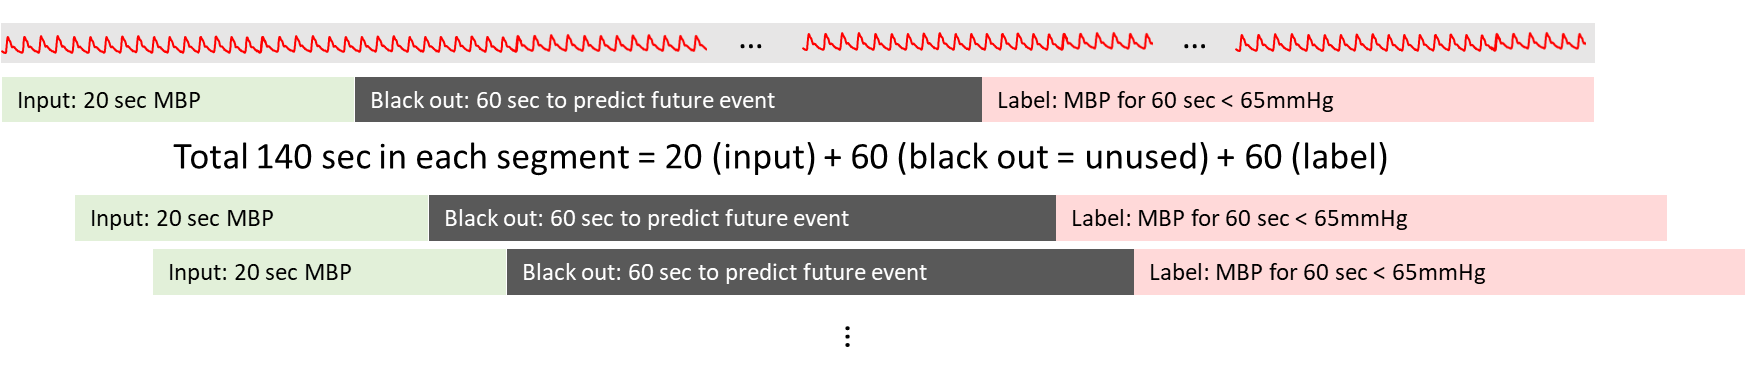

In [21]:
def make_segments(x, seglen, stride):
    # make_segments(np.arange(15), 5, 2)
    # [[ 0  1  2  3  4]
    #  [ 2  3  4  5  6]
    #  [ 4  5  6  7  8]
    #  [ 6  7  8  9 10]
    #  [ 8  9 10 11 12]
    #  [10 11 12 13 14]]
    nseg = (len(x) - seglen) // stride + 1
    return np.lib.stride_tricks.as_strided(x, strides=(x.strides[0] * stride,) + x.strides, 
                                              shape=(nseg, seglen) + x.shape[1:])

In [22]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 100  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['SNUADC/ART'], 1 / SRATE).flatten()

    case_sample = 0
    case_event = 0
    for i in range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        elif np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 200).any():
            valid = False
        elif (segy > 200).any():
            valid = False
        elif (segx < 30).any():
            valid = False
        elif (segy < 30).any():
            valid = False
        elif np.max(segx) - np.min(segx) < 30:
            valid = False
        elif np.max(segy) - np.min(segy) < 30:
            valid = False
        elif (np.abs(np.diff(segx)) > 30).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 30).any():  # abrupt change -> noise
            valid = False

        # 2 sec moving avg
        n = 2 * SRATE  
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100 * case_event / case_sample))
    else:
        print('no sample')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

# convert lists to numpy array
x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

# add axis for CNN
x = x[...,None]  

print(x.shape)
print(y.shape)

loading 2509...586 samples 0 (0.0 %) events
loading 4933...850 samples 50 (5.9 %) events
loading 3126...407 samples 19 (4.7 %) events
loading 5745...427 samples 0 (0.0 %) events
loading 3852...1256 samples 0 (0.0 %) events
loading 2970...1298 samples 0 (0.0 %) events
loading 3623...874 samples 45 (5.1 %) events
loading 5474...543 samples 0 (0.0 %) events
loading 2788...289 samples 0 (0.0 %) events
loading 6362...1126 samples 50 (4.4 %) events
loading 22...1183 samples 0 (0.0 %) events
loading 3355...225 samples 6 (2.7 %) events
loading 140...1623 samples 1 (0.1 %) events
loading 4241...1352 samples 0 (0.0 %) events
loading 716...864 samples 0 (0.0 %) events
loading 564...1581 samples 0 (0.0 %) events
loading 2072...1035 samples 11 (1.1 %) events
loading 5476...247 samples 0 (0.0 %) events
loading 53...953 samples 0 (0.0 %) events
loading 3725...794 samples 5 (0.6 %) events
loading 6273...862 samples 0 (0.0 %) events
loading 678...1561 samples 45 (2.9 %) events
loading 4498...1131 sampl

## Splitting samples into training and testing dataset


In [23]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# splitting into train set and test set
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), \
    len(train_y_valid), sum(train_y_valid), 100 * np.mean(train_y_valid), \
    len(test_y_valid), sum(test_y_valid), 100 * np.mean(test_y_valid))
print(testname)

100cases 1ahead batchsize=256 total 133198, train 76997 (1750 events 2.3%), test 20011 (723 events 3.6%)


## Model building and training

In [24]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# hyper parameter
CNN_LAYERS = [64] * 6

# build a model
model = Sequential()
for num_node in CNN_LAYERS:
    model.add(Conv1D(filters=num_node, kernel_size=3, padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
 66/271 [======>.......................] - ETA: 9:18 - loss: 0.2018 - accuracy: 0.9537 - auc: 0.9407

KeyboardInterrupt: ignored

## Evaluation of the model performance

In [ ]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_p = model.predict(test_x, BATCH_SIZE).flatten()
test_p_valid = test_p[valid_mask[test_mask]]

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_p_valid)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_p_valid)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_p_valid > thval)
acc = accuracy_score(test_y_valid, test_p_valid > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_p_valid > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

## Plotting each case in the test dataset

In [ ]:
for caseid in caseids_test:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = test_x[case_mask]
    case_y = test_y[case_mask]
    case_p = test_p[case_mask]
    case_valid_mask = valid_mask[test_mask][case_mask]
    case_p[~case_valid_mask] = np.nan
    if sum(case_valid_mask) == 0:
        continue
    
    # calculate error for this case
    case_rmse = np.nanmean(np.square(case_y - case_p)) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 6, i + MINUTES_AHEAD * 6 + 1, color='r', alpha=0.1, lw=0)
        if not case_valid_mask[i]:
            ax1.axvspan(i, i + 1, color='k', alpha=0.2, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples only
    ax2.plot(t, case_p)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()